# 3D Sensing and Sensor Fusion
### First Assignment - Kelemen Réka (E6T1DT)
***

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numba import prange, jit
from timeit import default_timer as timer

from stereo import stereo_estimation

# Parameters

In [2]:
focal_length = 3740
baseline = 160
window_size = 3
weight = 1000
scale = 2
dmin = 200
cost_type = "ssd"

# Load image

In [3]:
working_dir = os.getcwd()
print(working_dir)

C:\Users\rekak\Downloads\stereo_matching_e6t1dt


In [4]:
first = cv2.imread(working_dir + "/images/" + "aloe1.png", cv2.IMREAD_GRAYSCALE)
second = cv2.imread(working_dir + "/images/" + "aloe5.png", cv2.IMREAD_GRAYSCALE)
true = cv2.imread(working_dir + "/images/" + "aloe1_true.png", cv2.IMREAD_GRAYSCALE)

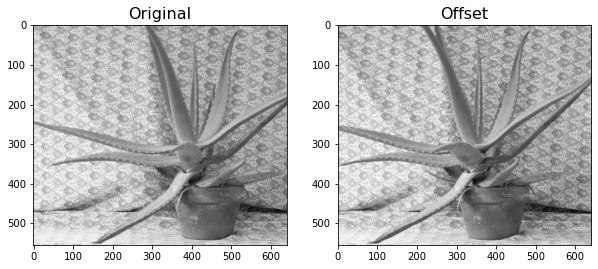

In [5]:
plt.figure(figsize=(10, 6))
images = [first, second]
titles = ["Original", "Offset"]
for i in range(1, 3):
    plt.subplot(120 + i)
    plt.title(titles[i - 1], fontsize=16)
    plt.imshow(images[i - 1], cmap="gray")

# Naive and DP stereo estimation

In [6]:
def call_with_monitor(function, display_name, verbose=True, **kwargs):
    start_time = timer()
    output = function(**kwargs)
    end_time = timer()
    elapsed_time = end_time - start_time
    if verbose:
        print("Time in seconds to complete", display_name, ":", round(elapsed_time, 6))
    return output, round(elapsed_time, 6)

In [7]:
height, width = first.shape

In [8]:
params = dict(
    window_size=window_size,
    height=height,
    width=width,
    left_image=first,
    right_image=second,
    scale=scale,
)

In [19]:
output_naive = call_with_monitor(
    stereo_estimation.naive_stereo_estimation,
    "naive stereo estimation",
    **params,
    cost_type=cost_type
)
output_dp = call_with_monitor(
    stereo_estimation.dynamic_programming_stereo_estimation,
    "DP stereo estimation",
    **params,
    weight=weight,
    cost_type=cost_type
)

Time in seconds to complete naive stereo estimation : 4.636186
Time in seconds to complete DP stereo estimation : 6.001798


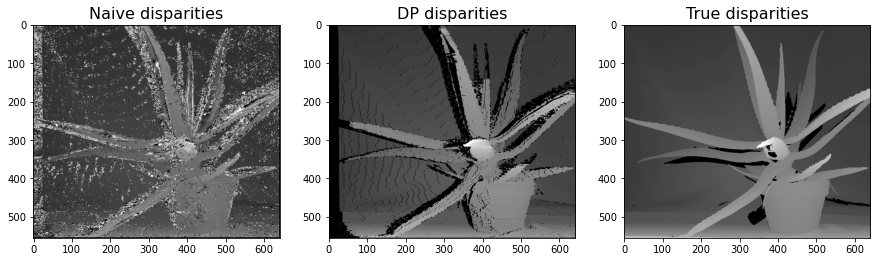

In [20]:
plt.figure(figsize=(15, 6))
titles = ["Naive disparities", "DP disparities", "True disparities"]
images = [output_naive[0], output_dp[0], true]
for i in range(1, 4):
    plt.subplot(130 + i)
    plt.title(titles[i - 1], fontsize=16)
    plt.imshow(images[i - 1], cmap="gray")

In [21]:
path = working_dir + "/output/point_clouds/"
stereo_estimation.write_to_point_cloud(
    width, height, output_dp[0], focal_length, baseline, dmin, scale, "art_dp", path
)

# Comparison

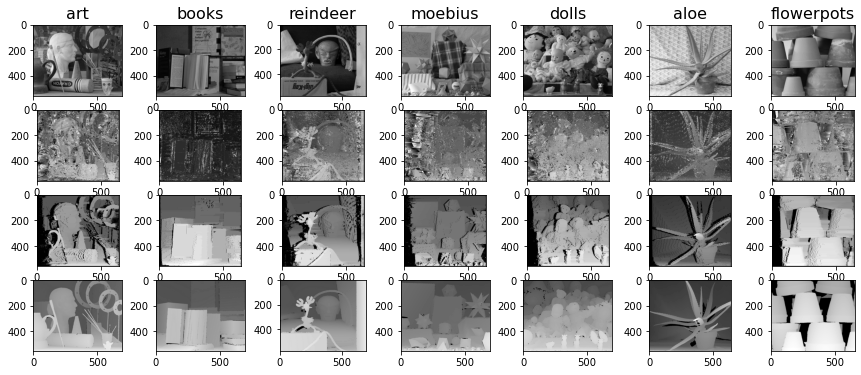

In [22]:
plt.figure(figsize=(15, 6))
dmin_dict = {"art": 200, "books": 200, "reindeer": 230, "moebius": 200, "dolls": 200, "aloe": 270, "flowerpots": 251}
file_names = list(dmin_dict.keys())
length = len(file_names)
times = []
images = []
for i in range(length):
    image1 = cv2.imread(working_dir + "/images/" + file_names[i] +"1.png", cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(working_dir + "/images/" + file_names[i] +"5.png", cv2.IMREAD_GRAYSCALE)
    ground_truth = cv2.imread(working_dir + "/images/" + file_names[i] +"1_true.png", cv2.IMREAD_GRAYSCALE)
    
    plt.subplot(4, length, i + 1)
    plt.title(file_names[i], fontsize=16)
    plt.imshow(image1, cmap="gray")
    
    output_naive = call_with_monitor(
    stereo_estimation.naive_stereo_estimation,
    "naive stereo estimation",
    verbose=False,
    window_size=window_size,
    height=height,
    width=width,
    left_image=image1,
    right_image=image2,
    scale=scale,
    cost_type=cost_type)
    
    output_dp = call_with_monitor(
    stereo_estimation.dynamic_programming_stereo_estimation,
    "DP stereo estimation",
    verbose=False,
    window_size=window_size,
    height=height,
    width=width,
    left_image=image1,
    right_image=image2,
    scale=scale,
    weight=weight,
    cost_type=cost_type)
    
    times.append([file_names[i], output_naive[1], output_dp[1]])
    images.append([ground_truth, output_naive[0], output_dp[0]])
    
    plt.subplot(4, length, i + 1 + length)
    plt.imshow(output_naive[0], cmap="gray")
    
    plt.subplot(4, length, i + 1 + (length * 2))
    plt.imshow(output_dp[0], cmap="gray")
    
    plt.subplot(4, length, i + 1 + (length * 3))
    plt.imshow(ground_truth, cmap="gray")
    
    cv2.imwrite(working_dir + "/output/images/" + file_names[i] + "_naive.png", output_naive[0])
    cv2.imwrite(working_dir + "/output/images/" + file_names[i] + "_dp.png", output_dp[0])
    
    stereo_estimation.write_to_point_cloud(
    width, height, output_dp[0], focal_length, baseline, dmin, dmin_dict[file_names[i]], file_names[i] + "_dp", path)
plt.savefig(working_dir + "/output/images/plot1.png")

In [23]:
print("dataset \t naive (s) \t dp (s)".expandtabs(tabsize=15))
for i in times:
    s = str(i[0]) + "\t" + str(i[1]) + "\t " + str(i[2])
    print(s.expandtabs(tabsize=15))

dataset         naive (s)      dp (s)
art            4.676081        1.965718
books          5.174953        6.146626
reindeer       3.975848        5.991386
moebius        5.221121        6.029514
dolls          5.214808        6.039045
aloe           5.187032        6.167884
flowerpots     5.204829        5.975877


# Effect of variables

In [14]:
def calculate_variable_effect(
    function_name=stereo_estimation.dynamic_programming_stereo_estimation,
    window_size=window_size, height=height, width=width, left_image=first, right_image=second, 
    scale=scale, weight=weight, cost_type=cost_type
):
    output_dp = call_with_monitor(
        function_name,
        display_name=None,
        verbose=False,
        window_size=window_size,
        height=height,
        width=width,
        left_image=first,
        right_image=second,
        scale=scale,
        weight=weight,
        cost_type=cost_type,
    )
    return output_dp

In [15]:
def plot_variable_effect(variable_name, list_of_values, length):
    plt.figure(figsize=(16, 5))
    params = {}
    for i in range(length):
        params[variable_name] = list_of_values[i]
        output_dp = calculate_variable_effect(**params)
        plt.subplot(1, length, i + 1)
        plt.title(str(variable_name) + " = " + str(list_of_values[i]) + "\n" + str(output_dp[1]) + " s", fontsize=16)
        plt.imshow(output_dp[0], cmap="gray")
    plt.savefig(working_dir + "/output/images/" + variable_name + "_effect.png")
    plt.show()

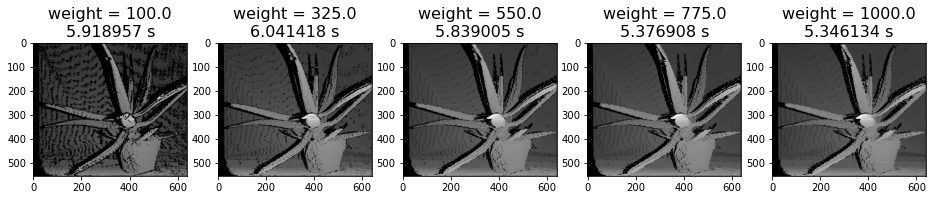

In [24]:
occlusions = np.linspace(100, 1000, 5)
plot_variable_effect("weight", occlusions, len(occlusions))

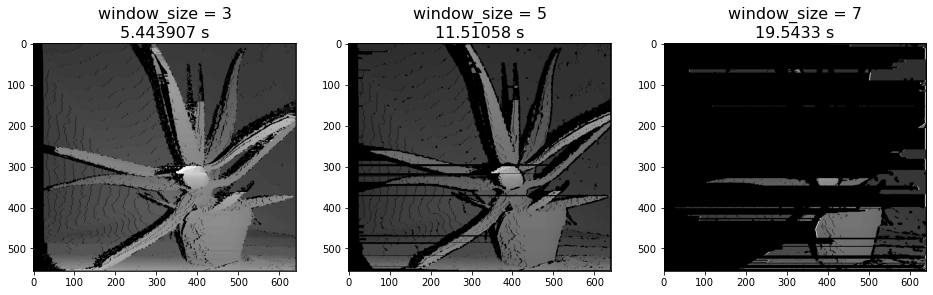

In [25]:
windows = [3, 5, 7]
plot_variable_effect("window_size", windows, len(windows))

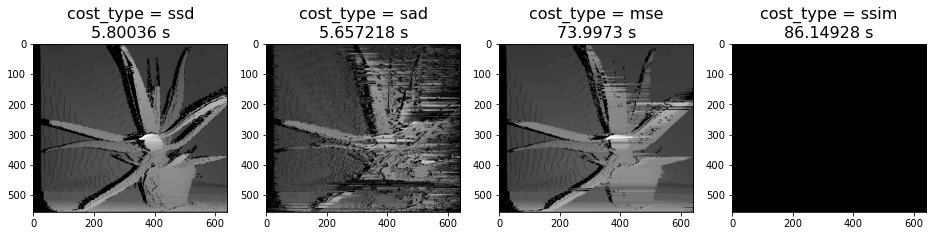

In [26]:
cost_types = ["ssd", "sad", "mse", "ssim"]
plot_variable_effect("cost_type", cost_types, len(cost_types))
# SSIM works well with weight=0